In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c elo-merchant-category-recommendation

100% 615M/615M [00:04<00:00, 105MB/s] 
100% 615M/615M [00:04<00:00, 144MB/s]


In [5]:
!unzip -q elo-merchant-category-recommendation.zip -d dataset/

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.pandas.set_option('display.max_columns',None)

In [7]:
merchants = pd.read_csv('dataset/merchants.csv')
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [8]:
new_tran = pd.read_csv('/content/dataset/new_merchant_transactions.csv')

In [9]:
new_tran.dropna(subset=['merchant_id'],inplace=True)

In [10]:
merch_tran = pd.merge(new_tran, merchants, how="left", on=["city_id", "category_1", "merchant_category_id", "merchant_id", "category_2", "state_id", "subsector_id"])

In [11]:
train_EDA = pd.read_csv("drive/MyDrive/train_EDA.csv")

In [12]:
elo_data = pd.merge(train_EDA, merch_tran, how="left", on=["card_id"])

In [50]:
dataset = elo_data.copy()

In [51]:
dataset.isnull().sum()

Unnamed: 0                          0
first_active_month                  0
card_id                             0
feature_1                           0
feature_2                           0
feature_3                           0
target                              0
year                                0
month                               0
authorized_flag                 22517
city_id                         22517
category_1                      22517
installments                    22517
category_3                      55855
merchant_category_id            22517
merchant_id                     22517
month_lag                       22517
purchase_amount                 22517
purchase_date                   22517
category_2                      91615
state_id                        22517
subsector_id                    22517
merchant_group_id              420601
numerical_1                    420601
numerical_2                    420601
most_recent_sales_range        420601
most_recent_

In [52]:
dataset = elo_data.dropna()

In [53]:
dataset.isnull().sum()

Unnamed: 0                     0
first_active_month             0
card_id                        0
feature_1                      0
feature_2                      0
feature_3                      0
target                         0
year                           0
month                          0
authorized_flag                0
city_id                        0
category_1                     0
installments                   0
category_3                     0
merchant_category_id           0
merchant_id                    0
month_lag                      0
purchase_amount                0
purchase_date                  0
category_2                     0
state_id                       0
subsector_id                   0
merchant_group_id              0
numerical_1                    0
numerical_2                    0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_

In [54]:
dataset.shape

(747514, 37)

In [55]:
dataset.drop("Unnamed: 0", inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##Handling Discrete Vars

In [56]:
# list of numerical variables
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
dataset[numerical_features].head()

Number of numerical variables:  26


,feature_1,feature_2,feature_3,target,year,month,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
1,5,2,1,-0.820283,2017,6,69.0,0.0,80.0,2.0,-0.666561,1.0,9.0,37.0,45545.0,-0.057471,-0.057471,1.05,1.159329,3.0,0.75,0.821384,5.0,0.75,0.821384,5.0
3,5,2,1,-0.820283,2017,6,69.0,0.0,842.0,2.0,-0.581180,1.0,9.0,37.0,78720.0,0.002019,-0.037641,0.99,0.986516,3.0,0.96,0.936156,6.0,0.90,0.879034,12.0
5,5,2,1,-0.820283,2017,6,69.0,0.0,454.0,1.0,-0.719890,1.0,9.0,39.0,86847.0,0.011934,-0.037641,1.01,0.994652,3.0,0.99,0.948663,6.0,0.97,0.931952,12.0
6,5,2,1,-0.820283,2017,6,69.0,0.0,278.0,1.0,-0.559933,1.0,9.0,37.0,15450.0,0.002019,-0.037641,0.98,1.016640,3.0,0.95,1.007515,6.0,0.92,0.999061,12.0
7,5,2,1,-0.820283,2017,6,69.0,0.0,683.0,1.0,-0.707223,1.0,9.0,34.0,35.0,105.585835,104.901707,1.08,1.090130,3.0,1.10,1.092221,6.0,1.13,1.117407,12.0


In [57]:
## Numerical variables are usually of 2 type
## 1. Continous variable and Discrete Variables

discrete_feature=[feature for feature in numerical_features if len(dataset[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 12


keeping discrete vars as it is

In [58]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 14


In [59]:
scale_list=["avg_purchases_lag12", "avg_sales_lag12", "avg_purchases_lag6", "avg_purchases_lag3", "numerical_2", "numerical_1"]

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()

In [62]:
scaled_data = dataset.copy()

In [25]:
scaled_data[scale_list] = scaler.fit_transform(dataset[scale_list])

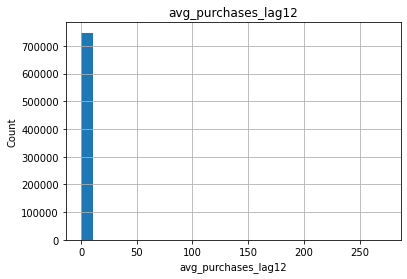

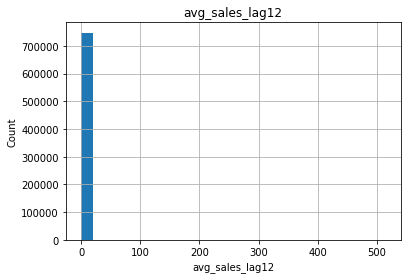

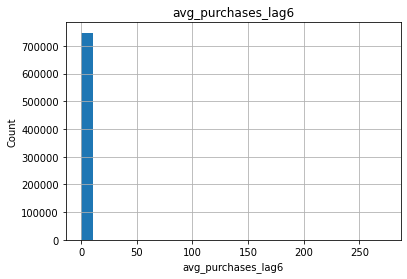

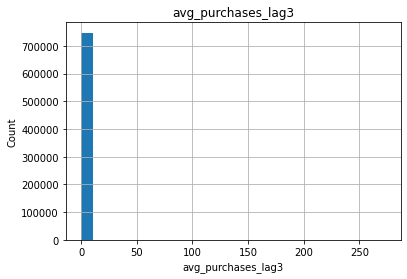

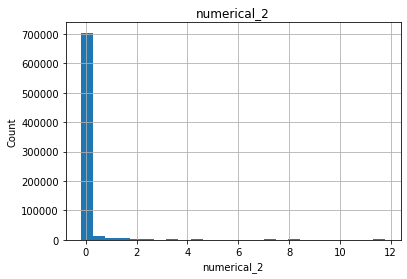

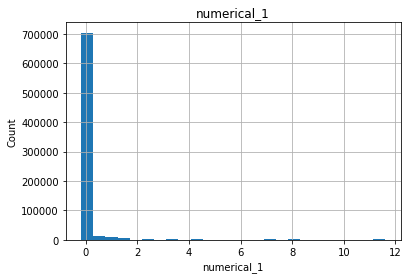

In [26]:
## Lets analyse the continuous values by creating histograms to understand the distribution
for feature in scale_list:
    data=scaled_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

standardization or normalization were not effective on the above features, now trying binarization

In [60]:
from sklearn.preprocessing import KBinsDiscretizer

In [61]:
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

In [63]:
est.fit(dataset[scale_list])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


KBinsDiscretizer(encode='ordinal', n_bins=3)

In [64]:
scaled_data[scale_list] = est.transform(dataset[scale_list])

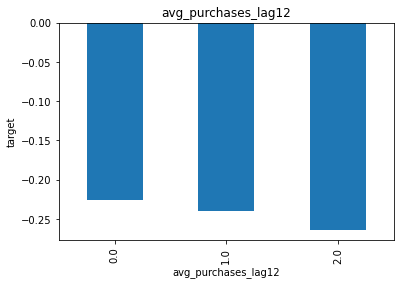

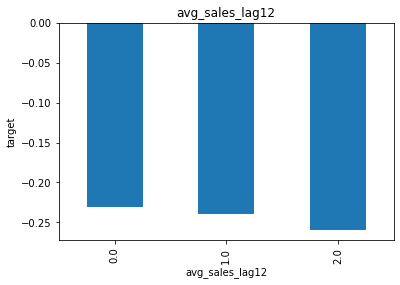

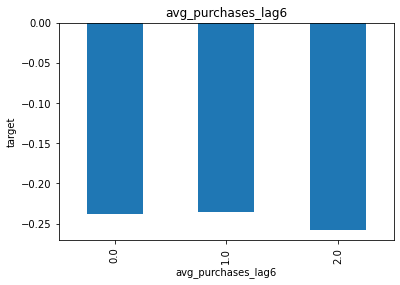

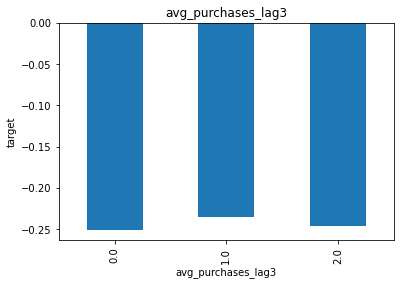

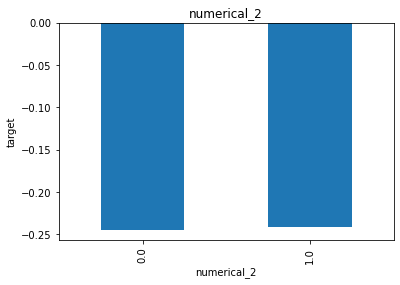

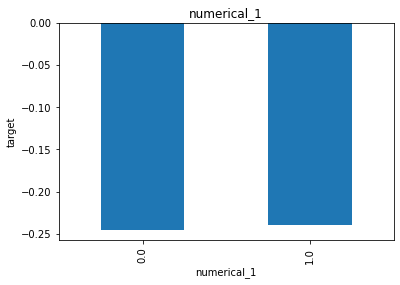

In [65]:
## Lets Find the realtionship between them and Sale PRice

for feature in scale_list:
    data=scaled_data.copy()
    data.groupby(feature)['target'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.title(feature)
    plt.show()

In [66]:
dataset[scale_list] = scaled_data[scale_list]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [67]:
continuous_drop_list = ["numerical_1", "numerical_2", "avg_purchases_lag6", "avg_sales_lag12"]

In [68]:
id_list = ["city_id", "merchant_category_id", "subsector_id", "merchant_group_id"]

In [34]:
scaled_data[id_list] = est.fit_transform(dataset[id_list])

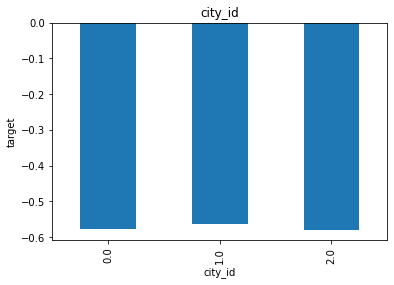

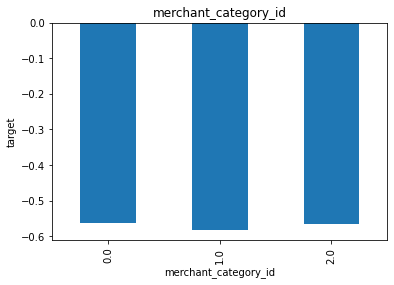

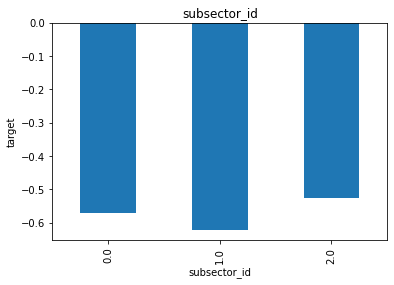

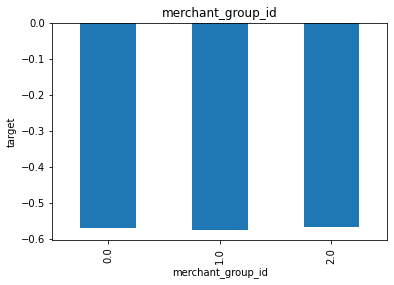

In [35]:
## Lets Find the realtionship between them and Sale PRice

for feature in id_list:
    data=scaled_data.copy()
    data.groupby(feature)['target'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.title(feature)
    plt.show()

In [69]:
dataset.drop(continuous_drop_list,inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [70]:
dataset.drop(id_list,inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
dataset.shape

(747514, 28)

##handling categorical labels

In [72]:
category_drop_list = ["authorized_flag", "category_1", "most_recent_sales_range", "category_4", "merchant_id", "first_active_month"]

In [73]:
dataset.drop(category_drop_list,inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
dataset.shape

(747514, 22)

In [75]:
categorical_list = ["category_3", "most_recent_purchases_range"]

In [76]:
ordinal_data = dataset.copy()

In [77]:
dict1={'B':1,'C':2,'A':3}
dict2={'A':1,'B':2,'C':3,'D':4,'E':5}

In [78]:
ordinal_data['category_3']=dataset['category_3'].map(dict1)

In [79]:
ordinal_data['most_recent_purchases_range']=dataset['most_recent_purchases_range'].map(dict2)

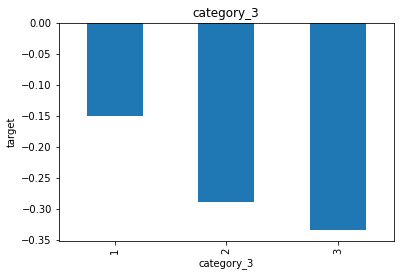

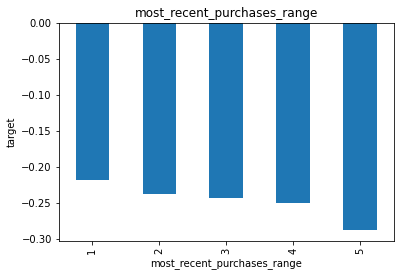

In [80]:
## Lets Find the realtionship between them and Sale PRice

for feature in categorical_list:
    data=ordinal_data.copy()
    data.groupby(feature)['target'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.title(feature)
    plt.show()

In [81]:
dataset[categorical_list] = ordinal_data[categorical_list]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747514 entries, 1 to 1229644
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   card_id                      747514 non-null  object 
 1   feature_1                    747514 non-null  int64  
 2   feature_2                    747514 non-null  int64  
 3   feature_3                    747514 non-null  int64  
 4   target                       747514 non-null  float64
 5   year                         747514 non-null  int64  
 6   month                        747514 non-null  int64  
 7   installments                 747514 non-null  float64
 8   category_3                   747514 non-null  int64  
 9   month_lag                    747514 non-null  float64
 10  purchase_amount              747514 non-null  float64
 11  purchase_date                747514 non-null  object 
 12  category_2                   747514 non-null  float64
 13

## Handling the date object

In [83]:
dataset['purchase_date'] = pd.to_datetime(dataset['purchase_date'], format = '%Y-%m-%d %H:%M:%S')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
dataset['purchase_date_year'] = dataset['purchase_date'].dt.year
dataset['purchase_date_month'] = dataset['purchase_date'].dt.month
dataset['purchase_date_week'] = dataset['purchase_date'].dt.week
dataset['purchase_date_day'] = dataset['purchase_date'].dt.day
dataset['purchase_date_hour'] = dataset['purchase_date'].dt.hour
dataset['purchase_date_minute'] = dataset['purchase_date'].dt.minute
dataset['purchase_date_dayofweek'] = dataset['purchase_date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we 

In [85]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747514 entries, 1 to 1229644
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   card_id                      747514 non-null  object        
 1   feature_1                    747514 non-null  int64         
 2   feature_2                    747514 non-null  int64         
 3   feature_3                    747514 non-null  int64         
 4   target                       747514 non-null  float64       
 5   year                         747514 non-null  int64         
 6   month                        747514 non-null  int64         
 7   installments                 747514 non-null  float64       
 8   category_3                   747514 non-null  int64         
 9   month_lag                    747514 non-null  float64       
 10  purchase_amount              747514 non-null  float64       
 11  purchase_date            

In [86]:
dataset.drop("purchase_date",inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [87]:
date_features = ['purchase_date_year', 'purchase_date_month', 'purchase_date_week', 'purchase_date_day', 'purchase_date_hour', 'purchase_date_minute', 'purchase_date_dayofweek']

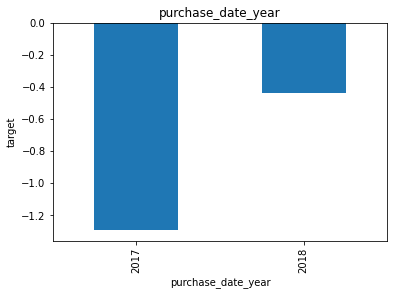

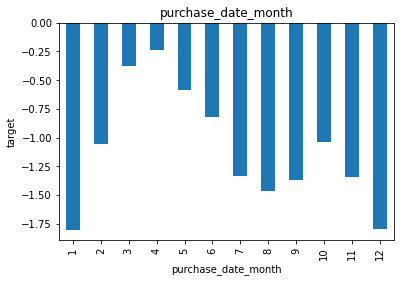

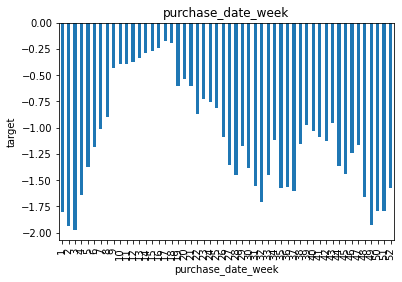

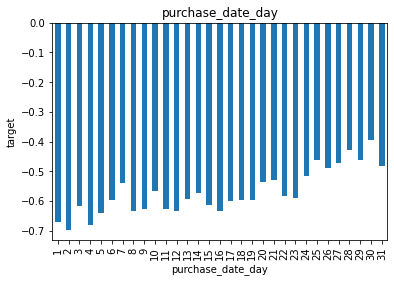

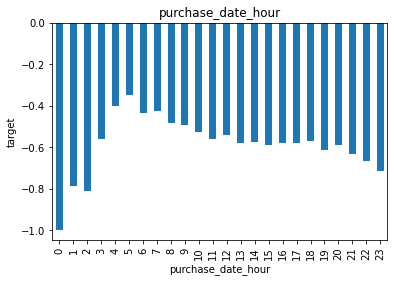

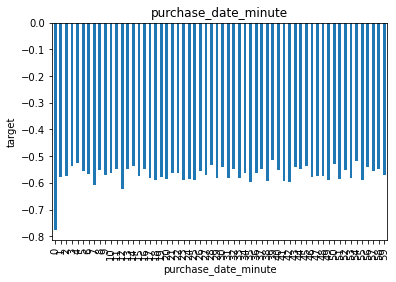

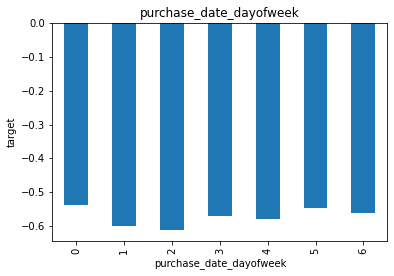

In [88]:
for feature in date_features:
    data=dataset.copy()
    data.groupby(feature)['target'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.title(feature)
    plt.show()

In [89]:
dataset.drop("purchase_date_dayofweek",inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
dataset.drop("purchase_date_minute",inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [91]:
dataset.drop("purchase_date_week",inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [92]:
final_features = dataset.columns

In [93]:
print(final_features)

Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'target', 'year',
       'month', 'installments', 'category_3', 'month_lag', 'purchase_amount',
       'category_2', 'state_id', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'active_months_lag6', 'avg_purchases_lag12',
       'active_months_lag12', 'purchase_date_year', 'purchase_date_month',
       'purchase_date_day', 'purchase_date_hour'],
      dtype='object')


In [147]:
dataset.shape

(747514, 25)

##Feature Selection

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
dataset.corr()

,feature_1,feature_2,feature_3,target,year,month,installments,category_3,month_lag,purchase_amount,category_2,state_id,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,active_months_lag6,avg_purchases_lag12,active_months_lag12,purchase_date_year,purchase_date_month,purchase_date_day,purchase_date_hour
feature_1,1.000000,-0.089571,0.565854,-0.013897,-0.085487,-0.022706,-0.036180,0.112036,0.004127,0.011116,-0.023672,-0.020906,0.011776,-0.000554,0.008748,0.003106,-0.000192,0.003634,0.006830,0.004335,-0.049337,0.036001,0.000245,-0.019664
feature_2,-0.089571,1.000000,0.011069,-0.019445,-0.134071,-0.046916,-0.084258,0.221459,0.004133,-0.035755,0.113095,0.050931,0.007595,0.000603,-0.001885,0.002905,0.000864,0.001225,0.003509,-0.001148,-0.044104,0.013761,0.003051,-0.002392
feature_3,0.565854,0.011069,1.000000,-0.021270,-0.161444,-0.022886,-0.180235,0.423666,-0.000710,-0.043566,-0.018836,-0.012011,-0.014798,-0.000391,0.015544,0.003667,-0.000456,0.003763,0.014530,0.001293,-0.050791,0.044659,-0.022914,-0.017939
target,-0.013897,-0.019445,-0.021270,1.000000,0.044578,0.049162,-0.003039,-0.019318,0.038159,-0.023410,0.003802,-0.007306,-0.006483,0.000053,0.000107,0.001197,-0.000067,-0.005890,-0.012687,-0.008634,0.112855,-0.084543,0.022132,-0.005850
year,-0.085487,-0.134071,-0.161444,0.044578,1.000000,-0.060696,0.067860,-0.172954,-0.007104,0.010123,0.017615,-0.016600,-0.009625,-0.005043,0.000581,0.000673,-0.004683,-0.001671,-0.010711,-0.000094,0.195899,-0.123589,0.001306,0.006222
month,-0.022706,-0.046916,-0.022886,0.049162,-0.060696,1.000000,0.017161,-0.049823,-0.008483,0.000467,-0.006806,-0.008039,-0.016725,0.000318,-0.000409,0.000898,0.000021,-0.002622,-0.008697,0.001071,0.185433,-0.144051,0.002733,-0.002597
installments,-0.036180,-0.084258,-0.180235,-0.003039,0.067860,0.017161,1.000000,-0.319874,-0.001095,0.222308,0.002947,-0.004983,0.042586,-0.000560,-0.024082,-0.002148,-0.000864,0.002416,0.006940,0.006434,0.031584,-0.026511,0.014010,0.027184
category_3,0.112036,0.221459,0.423666,-0.019318,-0.172954,-0.049823,-0.319874,1.000000,-0.000713,-0.026903,0.004914,0.014230,0.004549,0.002061,-0.001550,0.001943,0.002559,0.000952,0.009616,-0.001562,-0.097870,0.082916,-0.038094,-0.001094
month_lag,0.004127,0.004133,-0.000710,0.038159,-0.007104,-0.008483,-0.001095,-0.000713,1.000000,-0.001241,0.002719,-0.003495,0.006542,-0.002241,0.001310,0.000758,-0.000594,-0.025530,-0.012035,-0.018039,0.039939,0.123132,-0.003341,-0.008242
purchase_amount,0.011116,-0.035755,-0.043566,-0.023410,0.010123,0.000467,0.222308,-0.026903,-0.001241,1.000000,0.014945,-0.002209,0.087804,0.000137,-0.013872,-0.030514,0.002023,-0.013497,0.007574,-0.006502,0.007402,-0.006115,-0.001184,0.008258


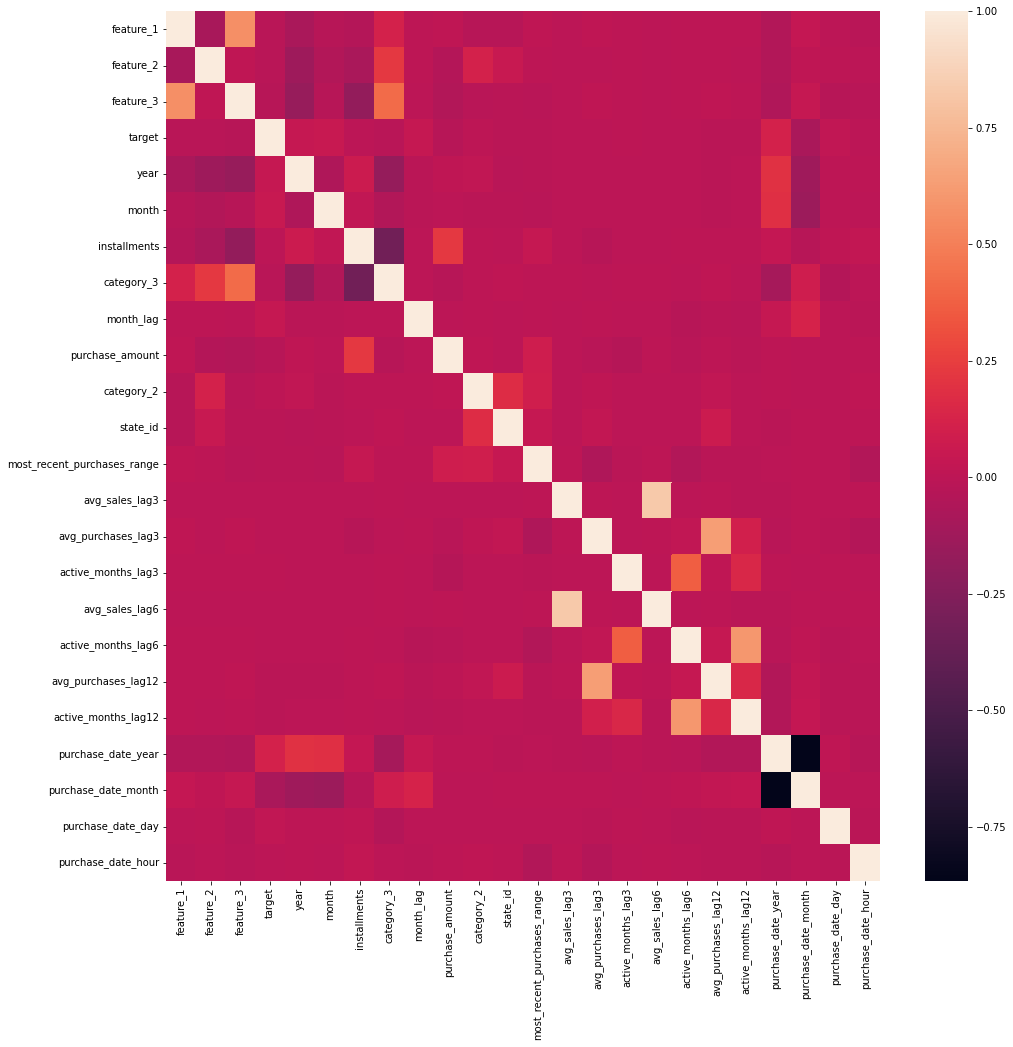

In [96]:
plt.figure(figsize=(16, 16))
sns.heatmap(dataset.corr());

In [97]:
dataset.to_csv("dataset.csv")

In [98]:
X = dataset.drop(["card_id","target"],axis=1)
y = dataset["target"]

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
from sklearn.metrics import mean_squared_error

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [102]:
regressor = DecisionTreeRegressor(max_depth=6, random_state=42)

In [103]:
regressor.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=6, random_state=42)

In [104]:
y_train_pred = regressor.predict(X_train)

In [105]:
mean_squared_error(y_train,y_train_pred,squared=False)

2.6997013361952105

In [106]:
y_test_pred = regressor.predict(X_test)

In [107]:
mean_squared_error(y_test,y_test_pred,squared=False)

2.742167348912744

## Manipulate test data same as train data

In [108]:
test_dataset = pd.read_csv('dataset/test.csv')

In [109]:
test_dataset.shape

(123623, 5)

In [110]:
test_dataset.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [111]:
test_dataset["year"]=0

In [112]:
test_dataset.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,year
0,2017-04,C_ID_0ab67a22ab,3,3,1,0
1,2017-01,C_ID_130fd0cbdd,2,3,0,0
2,2017-08,C_ID_b709037bc5,5,1,1,0
3,2017-12,C_ID_d27d835a9f,2,1,0,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1,0


In [113]:
test_dataset.iloc[2][0]

'2017-08'

In [114]:
test_dataset["first_active_month"] = test_dataset["first_active_month"].fillna("2017-09")

In [115]:
for i in range(test_dataset.shape[0]):
  test_dataset['year'][i] = int(test_dataset.iloc[i][0][0:4])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [116]:
test_dataset["month"]=0
for i in range(test_dataset.shape[0]):
  test_dataset['month'][i] = int(test_dataset.iloc[i][0][5:7])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
merch_tran1 = merch_tran.drop_duplicates(subset='card_id', keep="first")

In [155]:
test_dataset_merged = pd.merge(test_dataset, merch_tran1, how="left", on=["card_id"])

In [156]:
test_dataset_merged.shape

(123623, 35)

In [169]:
test_dataset_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   first_active_month           123623 non-null  object        
 1   card_id                      123623 non-null  object        
 2   feature_1                    123623 non-null  int64         
 3   feature_2                    123623 non-null  int64         
 4   feature_3                    123623 non-null  int64         
 5   year                         123623 non-null  int64         
 6   month                        123623 non-null  int64         
 7   authorized_flag              123623 non-null  object        
 8   city_id                      123623 non-null  float64       
 9   category_1                   123623 non-null  object        
 10  installments                 123623 non-null  float64       
 11  category_3                

In [170]:
test_dataset_merged.isnull().sum()

first_active_month             0
card_id                        0
feature_1                      0
feature_2                      0
feature_3                      0
year                           0
month                          0
authorized_flag                0
city_id                        0
category_1                     0
installments                   0
category_3                     0
merchant_category_id           0
merchant_id                    0
month_lag                      0
purchase_amount                0
purchase_date                  0
category_2                     0
state_id                       0
subsector_id                   0
merchant_group_id              0
numerical_1                    0
numerical_2                    0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_mon

In [159]:
test_dataset_merged['most_recent_purchases_range'] = test_dataset_merged['most_recent_purchases_range'].fillna('A')

In [160]:
test_dataset_merged['category_3'] = test_dataset_merged['category_3'].fillna('B')

active_month_lag3->3
\
active_month_lag6->6
\
active_month_lag12->12
\
installments->999
\
month_lag->2
\
category_2->5

In [162]:
test_dataset_merged['active_months_lag3'].fillna(3,inplace=True)

In [163]:
test_dataset_merged['active_months_lag6'].fillna(6,inplace=True)
test_dataset_merged['active_months_lag12'].fillna(12,inplace=True)
test_dataset_merged['installments'].fillna(999,inplace=True)
test_dataset_merged['month_lag'].fillna(2,inplace=True)
test_dataset_merged['category_2'].fillna(5,inplace=True)

In [164]:
continuous_na = ['avg_sales_lag3', 'avg_purchases_lag3', 'avg_sales_lag6', 'avg_purchases_lag12', 'purchase_amount', 'state_id']

In [165]:
for feature in continuous_na:
  test_dataset_merged.fillna(test_dataset_merged[feature].mean(),inplace=True)

Binarize the continuous vars

In [166]:
test_dataset_merged[scale_list] = est.transform(test_dataset_merged[scale_list])

ordinal encoding:

In [167]:
test_dataset_merged['category_3']=test_dataset_merged['category_3'].map(dict1)
test_dataset_merged['most_recent_purchases_range']=test_dataset_merged['most_recent_purchases_range'].map(dict2)

In [168]:
test_dataset_merged['purchase_date'] = pd.to_datetime(test_dataset_merged['purchase_date'], format = '%Y-%m-%d %H:%M:%S')

In [171]:
test_dataset_merged['purchase_date_year'] = test_dataset_merged['purchase_date'].dt.year
test_dataset_merged['purchase_date_month'] = test_dataset_merged['purchase_date'].dt.month
test_dataset_merged['purchase_date_week'] = test_dataset_merged['purchase_date'].dt.week
test_dataset_merged['purchase_date_day'] = test_dataset_merged['purchase_date'].dt.day
test_dataset_merged['purchase_date_hour'] = test_dataset_merged['purchase_date'].dt.hour
test_dataset_merged['purchase_date_minute'] = test_dataset_merged['purchase_date'].dt.minute
test_dataset_merged['purchase_date_dayofweek'] = test_dataset_merged['purchase_date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [172]:
final_test_features = ['feature_1', 'feature_2', 'feature_3', 'year',
       'month', 'installments', 'category_3', 'month_lag', 'purchase_amount',
       'category_2', 'state_id', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'active_months_lag6', 'avg_purchases_lag12',
       'active_months_lag12', 'purchase_date_year', 'purchase_date_month',
       'purchase_date_day', 'purchase_date_hour']

In [173]:
test_data = test_dataset_merged[final_test_features]

In [174]:
test_data.shape

(123623, 23)

In [175]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   feature_1                    123623 non-null  int64  
 1   feature_2                    123623 non-null  int64  
 2   feature_3                    123623 non-null  int64  
 3   year                         123623 non-null  int64  
 4   month                        123623 non-null  int64  
 5   installments                 123623 non-null  float64
 6   category_3                   123623 non-null  int64  
 7   month_lag                    123623 non-null  float64
 8   purchase_amount              123623 non-null  float64
 9   category_2                   123623 non-null  float64
 10  state_id                     123623 non-null  float64
 11  most_recent_purchases_range  123623 non-null  int64  
 12  avg_sales_lag3               123623 non-null  float64
 13 

In [176]:
y_pred = regressor.predict(test_data)

In [179]:
test_dataset_merged["target"]=0

In [180]:
test_dataset_merged["target"] = y_pred

In [182]:
submit=test_dataset_merged[['card_id', 'target']]

In [183]:
submit.head()

,card_id,target
0,C_ID_0ab67a22ab,-1.997040
1,C_ID_130fd0cbdd,-0.280632
2,C_ID_b709037bc5,-0.431093
3,C_ID_d27d835a9f,-0.431093
4,C_ID_2b5e3df5c2,-0.250497


In [184]:
submit.shape

(123623, 2)

In [187]:
test_dataset_merged.to_csv("test_dataset.csv")